# Chi squared distribution and tests

In this notebook we will present the chi squared distribution and the chi squared tests.

## 0. Preliminaries

In [1]:
from sklearn.datasets import load_iris
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import gamma
from sklearn.preprocessing import StandardScaler
import pandas as pd
from IPython.display import display
import scipy.stats as stats

In [2]:
data = load_iris()
data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [3]:
X = data['data'][:,0]

## 1. Computing the sample variance

First, we compute the sample variance of our data. We want an unbiased and consistent estimator so we use the formula by Byron et al. 

In [4]:
def sample_variance(X, ddof=1):
    X_bar = np.mean(X, axis = 0)
    n = X.shape[0]
    return (1/(n-ddof))*np.sum(np.power(X-X_bar, 2), axis = 0)

In [5]:
sample_variance(X) == np.var(X, axis = 0, ddof=1)

True

In [6]:
s2 = sample_variance(X)

## 2. Chi squared distribution

The distribution of s2 is, under mild assumptions, Normal, when data size is large. For small and moderate samples, this is not the case.

When observations $X_1,...,X_n$ are independent and Normal with $Var(X_i) = \sigma^2$ , the distribution of $$ \frac{(n-1)s²}{\sigma²} = \sum_{i=1}^n \left(\frac{X_i - \bar{X}}{\sigma}\right)^2$$ is Chi-square with $(n-1)$ degrees of freedom.

The Chi-squared distribution, $\chi^2$, has one parameter, $\nu$, indicating number of degrees of freedom. 
The density function is:
$$f(x) = \frac{1}{2^{\nu /2}\Gamma (\nu/2)} x^{\nu/2 -1}e^{-x/2}$$


In [7]:
def chi_squared_density(x, nu):
    temp = 1 / (np.power(2, nu/2)*gamma(nu/2))
    return temp * np.power(x, nu/2 -1)*np.exp(-x/2)

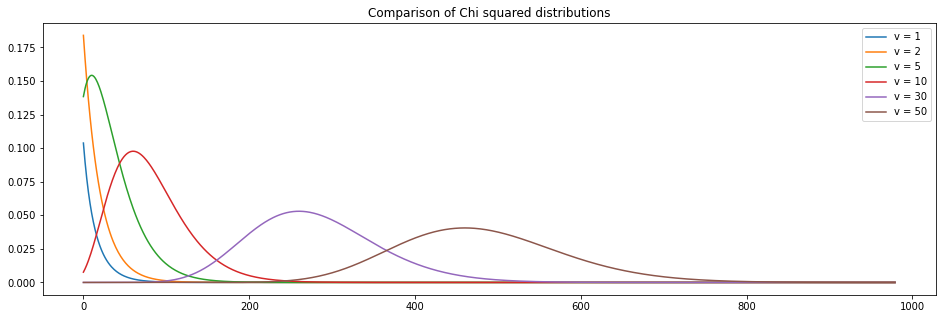

In [8]:
ddof = [1, 2, 5, 10, 30, 50]
x = np.arange(2, 100, 0.1)
plt.figure(figsize=(16,5))
for d in ddof:
    plt.plot(chi_squared_density(x, d), label = "v = {}".format(d))
plt.legend()
plt.title("Comparison of Chi squared distributions")
plt.show()

One of the applications of this chi squared distribution is constructing confidence intervals for the population variance. We will skip this procedure in this tutorial.

## 3. Chi squared tests
Several important tests of statistical hypotheses are based on the Chi-square distribution. These tests target categorical data, where we have the *counts* for each of the categories of our data. The general principle developed by Karl Pearson near year 1900 is to compare the observed counts against the expected counts via the chi-square statistic
$$ \chi^2  = \sum_{k = 1}{N} \frac{(Obs(k)-Exp(k))^2}{Exp(k)}$$

where $N$ is the number of categories in our data, $Obs(k)$ is the observed counts and $Exp(k)$ is the expected number of counts if the null hypothesis is true. This is always a one-sided, right-tail test because large values of $\chi^2$ indicate significant difference between the observed and expected data. Usually, the expected number of counts per bin is calculated as $Exp(k) = n p_k$, where $n$ is the sum of total counts and $p_k$ the probability of bin $k$.

The p-values is calculated as:
$$ p = P(\chi^2 > \chi^2_{obs})$$

If we want to apply this test, as a rule of thumb, we need at least 5 counts per category.


### 3.1 Testing a distribution

With the chi squared distribution we can test if the data belongs to a specific distribution.

* Ho: The data are consistent with a specified distribution.
* Ha: The data are **not** consistent with a specified distribution.

Let's visualize the sepal length of our iris setosa dataset and check if it is normally distributed. First, we need to "categorize" our data. To do so, we take the counts of each of the histogram bins.

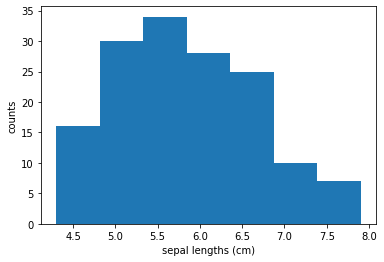

In [9]:
N = 7
counts, vals, bar = plt.hist(X, bins = N)
plt.ylabel("counts")
plt.xlabel("sepal lengths (cm)")
plt.show()

For the sake of simplicity, lets normalize the data so that we can compare it with a Standard normal distribution. We set manually the bins to categorize our data based on the standard deviation = 1.

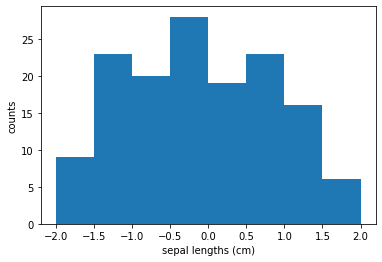

In [10]:
sc = StandardScaler()
X_stand = sc.fit_transform(X.reshape(-1, 1))
plt.figure()
bins = [-2, -1.5, -1,-0.5, 0, 0.5, 1,1.5,  2]
N = len(bins)-1
obs, limits, bar = plt.hist(X_stand, bins = bins)
plt.ylabel("counts")
plt.xlabel("sepal lengths (cm)")
plt.show()

By inspecting the counts we observe that we have at least 5 occurences per bin, as required. We will set the lower and upper bounds of the bins to infinity so that the sum of probabilities for all bins adds up to 1.

In [11]:
limits[0] = -np.inf 
limits[-1] = np.inf
obs, limits = np.histogram(X_stand, bins = limits)
N = len(limits)-1


In [12]:
print("Bin boundaries: ", limits)
print("Number of categories: ", N)
print("Observed counts: ", obs)
print("Sum of counts: ", sum(obs))


Bin boundaries:  [-inf -1.5 -1.  -0.5  0.   0.5  1.   1.5  inf]
Number of categories:  8
Observed counts:  [ 9 23 20 28 19 23 16 12]
Sum of counts:  150


We want to compare it against the standard normal distribution

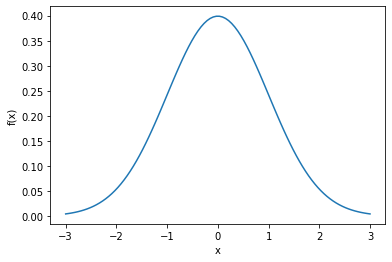

In [13]:
mu = 0
sigma = 1
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title
plt.show()

I didn't find much of guidance about how to compute the expected counts for a normal distribution, so what comes next is based on my reasoning. If we were dealing with a uniform distribution, the probability of each of the bins would be $1/N$. In our case, we need to compute the probability for each of the bins. 

In [14]:
pks = []
for i in range(1, len(limits)):
    cdf_upper_limit = stats.norm.cdf(limits[i])
    cdf_lower_limit = stats.norm.cdf(limits[i-1])
    prob = cdf_upper_limit - cdf_lower_limit
    pks.append(prob)
print("probability for each of the bins: ", pks)

probability for each of the bins:  [0.06680720126885807, 0.091848052662599, 0.1498822847945298, 0.19146246127401312, 0.19146246127401312, 0.1498822847945298, 0.09184805266259899, 0.06680720126885809]


In [15]:
assert np.sum(pks) == 1

We compute the expected counts and round up/down to get integers

In [16]:
n = np.sum(obs)
exp = np.round(np.multiply(n,pks))
exp

array([10., 14., 22., 29., 29., 22., 14., 10.])

In [17]:
assert sum(exp)==sum(obs)

and the chi squared statistic

In [18]:
def chi2_statistic(obs, exp):
    return np.sum(np.power(obs - exp, 2 )/exp)

In [19]:
chi2 =  chi2_statistic(obs, exp)
print("Our chi squared statistic is {}".format(chi2))

Our chi squared statistic is 10.281459919390953


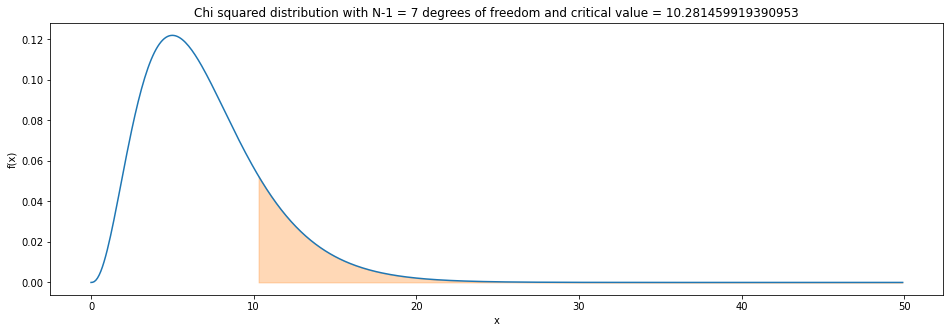

In [20]:
x = np.arange(0, 50, 0.1)
y = chi_squared_density(x, N-1)
plt.figure(figsize=(16,5))
plt.plot(x, y, label = "v = {}".format(N))
plt.fill_between(x, y, where=(x > chi2), color='C1', alpha=0.3,interpolate=True)
plt.title("Chi squared distribution with N-1 = {} degrees of freedom and critical value = {}".format(N-1, chi2))
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

In [21]:
p_value = 1 - stats.chi2.cdf(x = chi2, df = N-1)
p_value

0.17317653840964975

In [22]:
stats.chisquare(f_obs=obs, f_exp=exp)

Power_divergenceResult(statistic=10.281459919390953, pvalue=0.17317653840964972)

We see that our "by hand" results match those of scipy stats. Conclusion: we cannot reject H0 and therefore there is no enough evidence to say that normalized sepal length does not have a standard normal distribution.

A simpler example: rolls of a die and check if it is biased
* H0: the die has uniform distribution
* Ha: the die does not have uniform distribution

In [23]:
obs = np.array([20,15,12,17,9,17]) # counts for each of the 1-6 numbers
exp = np.array([15, 15, 15, 15, 15, 15]) # expected number of counts if the die is not biased
n = sum(obs)
chi2 =  chi2_statistic(obs, exp)
print("Our chi squared statistic is {}".format(chi2))
N = len(obs)
p_value = 1 - stats.chi2.cdf(x = chi2, df = N-1)
print("The p value is {}".format(p_value))


Our chi squared statistic is 5.2
The p value is 0.39196289159963393


In [24]:
stats.chisquare(f_obs=obs, f_exp=exp)

Power_divergenceResult(statistic=5.2, pvalue=0.39196289159963393)

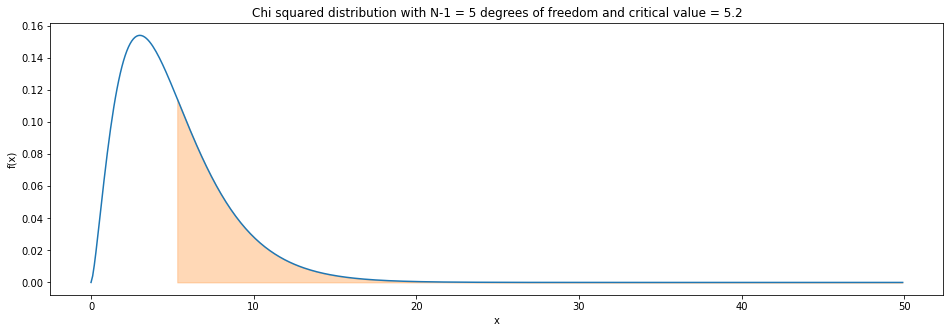

In [25]:
x = np.arange(0, 50, 0.1)
y = chi_squared_density(x, N-1)
plt.figure(figsize=(16,5))
plt.plot(x, y, label = "v = {}".format(N))
plt.fill_between(x, y, where=(x > chi2), color='C1', alpha=0.3,interpolate=True)
plt.title("Chi squared distribution with N-1 = {} degrees of freedom and critical value = {}".format(N-1, chi2))
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

## 3.2 Testing a family of distributions

Instead of testing if the distribution of the data belongs to a specific distribution (such as the standard normal) we can directly check if it belongs to a entire family of distributions (normal, exponential, poisson, etc). This is, we do not know the parameters that define the distribution that we are looking for (mean, standad deviation, etc). In this case, we will estimate the unkown parameters with the data, and reduce the number of degrees of freedom of the chi-square distribution based on the number of estimated parameters. 

We will take the non-normalized setosa sepal length data to show this test.
* H0: the data belongs to the family of normal distributions.
* Ha: the data does not follow normal distribution.

Steps:
1. Estimate via maximum likelihood the unkown parameters. Assume a specific distribution based on these found parameters.


In [26]:
mean_estimate = np.mean(X)
std_estimate = np.sqrt(sample_variance(X))
d = 2 #number of estimated parameters
print("Estimated mean:", mean_estimate)
print("Estimated standard deviation: ", std_estimate)

Estimated mean: 5.843333333333334
Estimated standard deviation:  0.828066127977863


2. Partition the data in bins, preferebly $N \in [5,8]$

In [27]:
counts, limits = np.histogram(X, 7) #take initial histogram
limits[0], limits[-1] = -np.inf, np.inf #modify the limits to account for extreme values 
obs, limits = np.histogram(X, limits) # counts observations per bin
N = len(obs)
n = sum(obs)

3.  Compute probabilities based on the estimated parameters

In [28]:
pks = []
for i in range(1, len(limits)):
    cdf_upper_limit = stats.norm.cdf( limits[i], loc= mean_estimate, scale = std_estimate)
    cdf_lower_limit = stats.norm.cdf(limits[i-1], loc= mean_estimate, scale = std_estimate)
    prob = cdf_upper_limit - cdf_lower_limit
    pks.append(prob)
print("probability for each of the bins: ", pks)

probability for each of the bins:  [0.10698701130549892, 0.16010115255736918, 0.23268241906814718, 0.2327629008860166, 0.16026736689314824, 0.07594199095608845, 0.03125715833373144]


In [29]:
assert np.sum(pks) == 1

4. Compute the observed counts, the expected counts and the chi squared statistic.

In [30]:
exp = np.round(np.multiply(n,pks))
exp

array([16., 24., 35., 35., 24., 11.,  5.])

In [31]:
assert sum(exp)==sum(obs)

In [32]:
chi2 =  chi2_statistic(obs, exp)
print("Observed: ", obs)
print("Expected: ", exp)
print("Our chi squared statistic is {}".format(chi2))

Observed:  [16 30 34 28 25 10  7]
Expected:  [16. 24. 35. 35. 24. 11.  5.]
Our chi squared statistic is 3.8611471861471856


5. Compute the P-value or construct the rejection region using Chi-square distribution with (N − d − 1) degrees of freedom, where d is the number of estimated parameters. State conclusions.

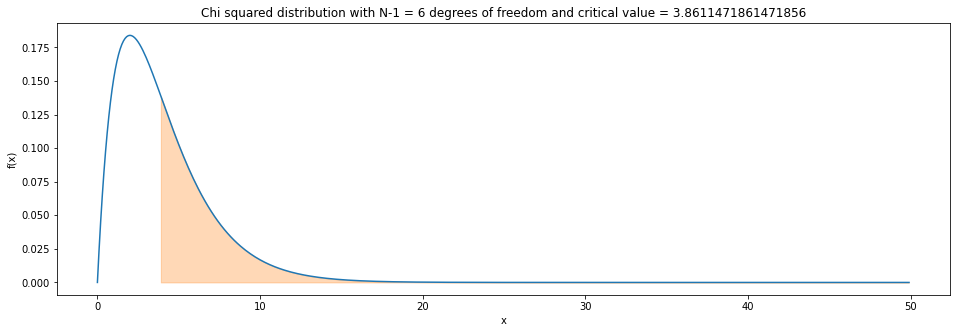

In [33]:
x = np.arange(0, 50, 0.1)
y = chi_squared_density(x, N-d-1)
plt.figure(figsize=(16,5))
plt.plot(x, y, label = "v = {}".format(N))
plt.fill_between(x, y, where=(x > chi2), color='C1', alpha=0.3,interpolate=True)
plt.title("Chi squared distribution with N-1 = {} degrees of freedom and critical value = {}".format(N-1, chi2))
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

In [34]:
p_value = 1 - stats.chi2.cdf(x = chi2, df = N-d-1)
print("The p value is {}".format(p_value))

The p value is 0.4251235596809432


There is not enough evidence to reject the null hypothesis --> data is asumed to be normal

## 3.3 Testing independence

Many practical applications require testing independence of two factors. Chi square tests can help us test:
* H0: factors A and B are independent
* Ha: factors A and B are dependent

We can partition each of the factors in bins, like done previously and rewrite the test as:
* H0: $P(x \in A_i \cap B_j) = P(x\in A_i)P(x\in B_j)$ for all $i,j$
* Ha: $P(x \in A_i \cap B_j) \neq P(x\in A_i)P(x\in B_j)$ for some $i,j$

We can design a contigency table with the counts for each of the categories and their intersection. In this tutorial we will call:
* $n_{ij}$ the count of the intersection, this is, the number of counts that belong both to $A_i$ and $B_j$. This corresponds to the *observed counts*
* $n_{i\cdot}$ the count of ocurrences in $A_i$ 
* $n_{\cdot j}$ the count of ocurrences in $B_j$ 
* $n$ the total sum of counts
The expected counts is computed as $$ Exp(i,j) = n\frac{n_{i\cdot}}{n}\frac{n_{\cdot j}}{n} = \frac{n_{i\cdot}n_{\cdot j}}{n}$$

Then, we can compute the chi statistic as usual and compare it to a chi squared distribution with $(k-1)(m-1)$ degrees of freedom, where $k$ is the number of categories for factor $A$ and $m$ is the number of categories for factor $B$.

#### Testing features that are independent of breast cancer

Let's test if some of the features in the breast cancer dataset are pairwise independent (H0) to having breast cancer.

In [35]:
data = load_breast_cancer()
features = data.feature_names
df = pd.DataFrame(data['data'], columns = features)
df['cancer'] = data.target
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,cancer
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


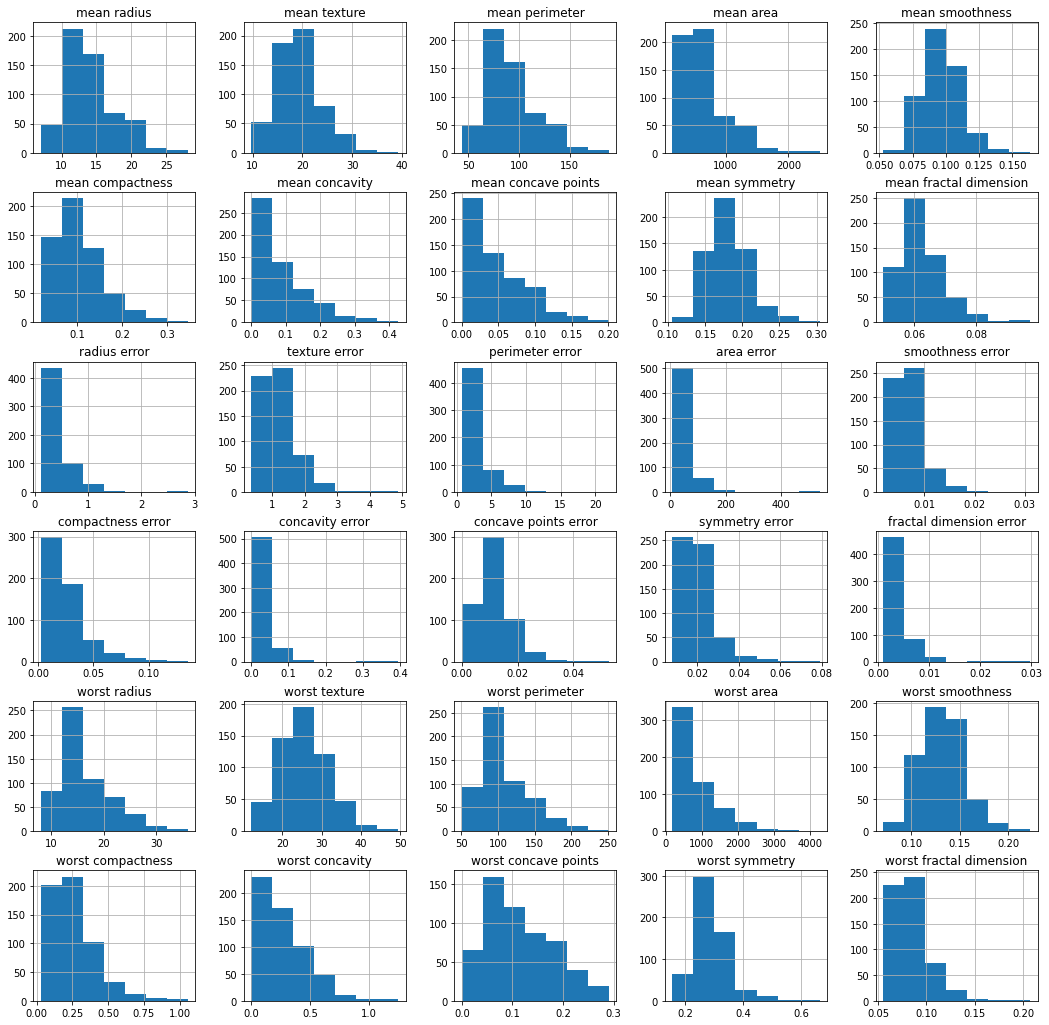

In [36]:
fig= df[features].hist(bins = 7, figsize=(18,18))
plt.show()

First, we categorize the data into $m$ bins. For this example, we chose the feature "worst concave points".

In [37]:
col = "worst concave points"
N = 7
counts, limits = np.histogram(df[col].values, bins = N)
counts, limits

(array([ 65, 160, 121,  87,  77,  40,  19]),
 array([0.        , 0.04157143, 0.08314286, 0.12471429, 0.16628571,
        0.20785714, 0.24942857, 0.291     ]))

In [38]:
k = 2
m= N
categories = pd.cut(df[col],  bins = limits, include_lowest = True, labels = np.arange(0,m,1))
df[col+' cat'] = categories
display(df[[col+' cat', 'cancer']])

,worst concave points cat,cancer
0,6,0
1,4,0
2,5,0
3,6,0
4,3,0
...,...,...
564,5,0
565,3,0
566,3,0
567,6,0


In [39]:
print("Contingency table for feature {}".format(col))
ct = pd.crosstab(categories, df['cancer'] )
n = np.sum(ct.values)
ct.loc['$n_{\cdot i}$'] = np.sum(ct.values, axis = 0)#count of ocurrences of our feature in each of the ranges
ct['$n_{j \cdot }$'] = np.sum(ct.values, axis = 1)
ct

Contingency table for feature worst concave points


cancer,0,1,$n_{j \cdot }$
worst concave points,,,
0,1,64,65
1,3,157,160
2,19,102,121
3,55,32,87
4,75,2,77
5,40,0,40
6,19,0,19
$n_{\cdot i}$,212,357,569


Let's check how to calculate the chi square statistic for the our feature.

In [40]:
obs = ct.iloc[0:7, 0:2].values
obs

array([[  1,  64],
       [  3, 157],
       [ 19, 102],
       [ 55,  32],
       [ 75,   2],
       [ 40,   0],
       [ 19,   0]])

In [41]:
n_idot = ct.iloc[7, 0:2].values
n_idot

array([212, 357])

In [42]:
n_dotj = ct.iloc[0:7,2].values
n_dotj

array([ 65, 160, 121,  87,  77,  40,  19])

In [43]:
exp = np.zeros(obs.shape)
probs = np.zeros(obs.shape)
for i in range(k):
    for j in range(m):
        probs[j,i] = (n_idot[i]/n)*(n_dotj[j]/n)
        exp[j,i] = n* probs[j,i]
exp


array([[ 24.21792619,  40.78207381],
       [ 59.61335677, 100.38664323],
       [ 45.08260105,  75.91739895],
       [ 32.41476274,  54.58523726],
       [ 28.68892794,  48.31107206],
       [ 14.90333919,  25.09666081],
       [  7.07908612,  11.92091388]])

In [44]:
assert np.round(np.sum(probs),5) == 1

In [45]:
chi2 =  chi2_statistic(obs, exp)
print("Our chi squared statistic is {}".format(chi2))
N = len(obs)
p_value = 1 - stats.chi2.cdf(x = chi2, df =(k-1)*(m-1))
print("The p value is {}".format(p_value))


Our chi squared statistic is 388.80696065718945
The p value is 0.0


We have a very very low p-value, so we can reject the null hypothesis and state that the feature "worst concave points" is dependent on breast cancer.

## 4. Summary

In this tutorial, we provide theory, step by step explanations and examples for some of the most common uses of the chi squared distribution.